In [1]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

2024-04-11 16:43:07.215879: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-11 16:43:07.215986: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-11 16:43:07.348567: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
main_directory = '/kaggle/input/pins-face-recognition/105_classes_pins_dataset'
width, height = 224,224

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.regularizers import l1_l2
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    validation_split=0.2  # %20'sini doğrulama seti olarak ayır
)

train_generator = train_datagen.flow_from_directory(
    main_directory,
    target_size=(width, height),
    batch_size=128,
    class_mode='categorical',
    subset='training',  # Eğitim seti için
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    main_directory,
    target_size=(width, height),
    batch_size=128,
    class_mode='categorical',
    subset='validation',  # Doğrulama seti için
    shuffle=True
)



Found 14071 images belonging to 105 classes.
Found 3463 images belonging to 105 classes.


In [5]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Conv2D, GlobalAveragePooling2D,AveragePooling2D, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l1, l2, l1_l2
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(width, height, 3))

for layer in base_model.layers:
    layer.trainable = False
    
# Global spatial average pooling layer'ı ekleyin
x = base_model.output
x = BatchNormalization()(x)
x = Conv2D(1024, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = AveragePooling2D(pool_size=(2, 2))(x)  
x = Flatten()(x)
x = BatchNormalization()(x)


x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.50)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.50)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.50)(x)
# Çıktı katmanını tanımlayın
predictions = Dense(105, activation='softmax')(x)

# Eğitilecek modeli oluşturun
model = Model(inputs=base_model.input, outputs=predictions)



# Modeli derleyin
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 47,354,473 (180.64 MB)

 Trainable params: 23,771,753 (90.68 MB)

 Non-trainable params: 23,582,720 (89.96 MB)

In [6]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
# Modeli derleme
early_stopping = EarlyStopping(
    monitor='val_loss', # İzlenecek metrik
    patience=10, # Metrikte iyileşme olmaması durumunda beklenilecek epoch sayısı
    verbose=1, # Eğitimin durdurulduğuna dair bilgilendirme mesajı
    restore_best_weights=True # En iyi ağırlıkların geri yüklenip yüklenmeyeceği
)
# Modeli eğitme
history = model.fit(
    train_generator,
    #steps_per_epoch=100,  # epoch başına adımlar
    epochs=100,
    validation_data=validation_generator,
    callbacks=[early_stopping],
    #validation_steps=50  # doğrulama seti üzerindeki adım sayısı
)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/110 ━━━━━━━━━━━━━━━━━━━━ 1:37:45 54s/step - accuracy: 0.0078 - loss: 6.0192

I0000 00:00:1712853975.927025      95 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


110/110 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.0257 - loss: 5.2480 - val_accuracy: 0.0915 - val_loss: 4.1010
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 50s 428ms/step - accuracy: 0.0898 - loss: 4.0073 - val_accuracy: 0.1923 - val_loss: 3.2974
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 50s 435ms/step - accuracy: 0.1779 - loss: 3.3405 - val_accuracy: 0.2544 - val_loss: 2.9667
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 49s 426ms/step - accuracy: 0.2987 - loss: 2.7060 - val_accuracy: 0.3153 - val_loss: 2.7274
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 49s 420ms/step - accuracy: 0.4458 - loss: 2.0462 - val_accuracy: 0.3488 - val_loss: 2.5406
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 49s 423ms/step - accuracy: 0.6043 - loss: 1.4564 - val_accuracy: 0.3820 - val_loss: 2.4296
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 49s 419ms/step - accuracy: 0.7519 - loss: 0.9458 - val_accuracy: 0.3867 - val_loss: 2.4993
Epoch 8/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 49s 420ms/step - accuracy: 0.8607 - loss: 0.5555 

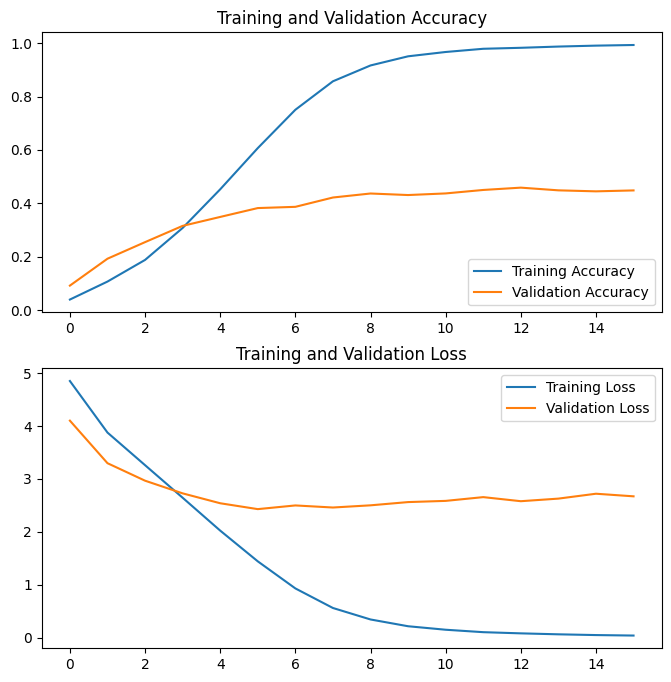

In [7]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [8]:
from sklearn.metrics import classification_report, confusion_matrix

# Modelin test veri seti üzerinde tahmin yapması
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # En yüksek olasılığa sahip sınıfı seç

# Confusion matrisi ve sınıflandırma raporunu hesaplama
cm = confusion_matrix(y_test_encoded, y_pred_classes)
cr = classification_report(y_test_encoded, y_pred_classes, target_names=label_encoder.classes_)

print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(cr)

NameError: name 'X_test' is not defined

In [9]:
model.save('yuz_tanima_modeli_Resnet.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Tahmin edilen sınıf ismi: pins_Morgan Freeman


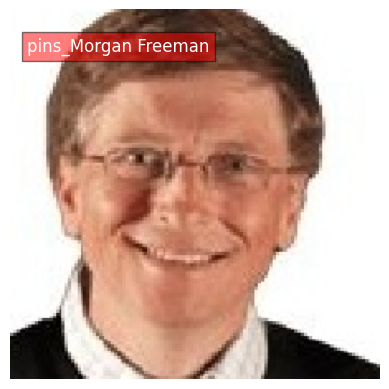

In [12]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Modeli yükle
model = load_model('/kaggle/working/yuz_tanima_modeli_Resnet.h5')

class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
# Test resmini yükle
img_path = '/kaggle/input/pins-face-recognition/105_classes_pins_dataset/pins_Bill Gates/Bill Gates109_503.jpg'  # Test etmek istediğiniz resmin yolu
img = image.load_img(img_path, target_size=(width, height))  # width ve height modelinizle eşleşmeli
img_array = image.img_to_array(img)  # Resmi array'e dönüştür
img_array = np.expand_dims(img_array, axis=0)  # Model için doğru shape'e getir
img_array /= 255.0  # Normalizasyon

predictions = model.predict(img_array)
predicted_class_indices = np.argmax(predictions, axis=1)  # En yüksek olasılıkla tahmin edilen sınıf indeksi
predicted_class_name = class_names[predicted_class_indices[0]]  # Sınıf ismini al

# Tahmin sonuçlarını yazdır
print("Tahmin edilen sınıf ismi:", predicted_class_name)

plt.imshow(img)
plt.axis('off')  # Eksenleri kapat

# Tahmin edilen etiketi resmin üzerine yaz
# (10, 25) başlangıç konumunu belirtir. Bu değerleri ayarlayarak metnin pozisyonunu değiştirebilirsiniz.
plt.text(10, 25, predicted_class_name, color='white', fontsize=12, 
         bbox=dict(facecolor='red', alpha=0.5))

# Görseli göster
plt.show()
